In [1]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from pprint import pprint

In [2]:
def load_and_prepare_artembev(header=None):
    res = pd.read_excel('../data/1Artembev_PhC_sport_and_tripms.xls', header=header)
    res = res[['Physiological Cost (PhC)', 'TRIMP1', 'TRIMP2', 'TRIMP3', 'TRIMP4']]
    res['PhC'] = res['Physiological Cost (PhC)']
    res.drop(columns=["Physiological Cost (PhC)"], inplace=True)
    return res[11::]

In [3]:
def load_and_prepare_others(header=None):
    columns_to_remain = ['PhC', "t1(passive,slow)", "t2(passive,fast)", "t3(active,slow)", 't4(active,fast)']
    prokopbev = pd.read_excel('../data/2Prokopbev_PhC_sport_and_tripms.xls', header=header)
    prokopbev = prokopbev[columns_to_remain]
    prokopbev['TRIMP1'] = prokopbev["t1(passive,slow)"]
    prokopbev['TRIMP2'] = prokopbev["t2(passive,fast)"]
    prokopbev['TRIMP3'] = prokopbev["t3(active,slow)"]
    prokopbev['TRIMP4'] = prokopbev['t4(active,fast)']
    volkov = pd.read_excel('../data/3Volkov_PhC_sport_and_tripms.xls', header=header)
    volkov = volkov[columns_to_remain]
    volkov['TRIMP1'] = volkov["t1(passive,slow)"]
    volkov['TRIMP2'] = volkov["t2(passive,fast)"]
    volkov['TRIMP3'] = volkov["t3(active,slow)"]
    volkov['TRIMP4'] = volkov['t4(active,fast)']
    
    cols_to_remove = ["t1(passive,slow)", "t2(passive,fast)", "t3(active,slow)", 't4(active,fast)']
    
    prokopbev.drop(columns=cols_to_remove, inplace=True)
    volkov.drop(columns=cols_to_remove, inplace=True)
    return prokopbev[8::], volkov[34::]

In [4]:
artembev = load_and_prepare_artembev(0)
prokopbev, volkov = load_and_prepare_others(0)

In [5]:
spacemen_initial = {'3rd_Spaceman': volkov, "2nd_Spaceman": prokopbev, "1st_Spaceman": artembev}

In [6]:
spacemen = {}
for man in spacemen_initial:
    spacemen[man] = spacemen_initial[man].copy()
    spacemen[man]["PhC"] = spacemen[man]["PhC"][1::]
    
    cols_to_drop = []
    for col in spacemen[man].columns:
        spacemen[man][col+'_mean_3_days'] = np.asarray([spacemen[man].loc[i-1:i+1, col].mean() 
                                                        for i in spacemen[man].index])
        cols_to_drop.append(col)
        
    OLD_PHC_COLNAME = "PhC_mean_3_days"
    NEW_PHC_COLNAME = 'PhC_mean_target_3_days'
    spacemen[man][NEW_PHC_COLNAME] = spacemen[man][OLD_PHC_COLNAME][3::].tolist() + 3*[np.nan]
    spacemen[man][OLD_PHC_COLNAME] = np.asarray([spacemen[man].loc[i-2:i, "PhC"].mean() 
                                                 for i in spacemen[man].index])
    
    spacemen[man].drop(columns=cols_to_drop, inplace=True)
    spacemen[man].dropna(inplace=True)
    print(f'{man} is ready. Contains {spacemen[man].shape[0]} samples')

3rd_Spaceman is ready. Contains 124 samples
2nd_Spaceman is ready. Contains 82 samples
1st_Spaceman is ready. Contains 124 samples


In [7]:
def train_and_test(X, y, max_depth=None, draw=False):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)
    tree = DecisionTreeRegressor(max_depth=max_depth)
    tree = tree.fit(X_train, y_train)
    y_pred = tree.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    mae = np.mean(np.abs(y_test - y_pred))
    if draw:
        print(f'R^2 = {r2}')
        print(f'MAE = {mae}')
        plt.figure(figsize=(7,7))
        sns.scatterplot(y_test, y_pred)
    return r2, mae

In [75]:
def train_and_test_shuffled(X, y, max_depth=None, draw=False):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)
    tree = DecisionTreeRegressor(max_depth=max_depth)
    tree = tree.fit(X_train, y_train)
    y_pred = tree.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    mae = np.mean(np.abs(y_test - y_pred))
    if draw:
        print(f'R^2 = {r2}')
        print(f'MAE = {mae}')
        plt.figure(figsize=(7,7))
        plt.xlabel('Истинное значение')
        plt.ylabel('Прогноз')
        sns.scatterplot(y_test, y_pred)
    return r2, mae

In [107]:
def iterate_over_depths(X, y, train_script, depth_limit=100):
    r_scores = []
    depths = []
    for i in range(1, depth_limit):
        depths.append(i)
        r_scores.append(train_script(X, y, i)[0])
    plt.figure(figsize=(14, 7))
    plt.xlabel('Глубина дерева')
    plt.ylabel('Величина R²')
    sns.lineplot(depths, r_scores)
    return r_scores, depths

In [77]:
y = spacemen["2nd_Spaceman"][NEW_PHC_COLNAME]
X = spacemen["2nd_Spaceman"].drop(columns=[NEW_PHC_COLNAME])
X.columns, y.name

(Index(['PhC_mean_3_days', 'TRIMP1_mean_3_days', 'TRIMP2_mean_3_days',
        'TRIMP3_mean_3_days', 'TRIMP4_mean_3_days'],
       dtype='object'), 'PhC_mean_target_3_days')

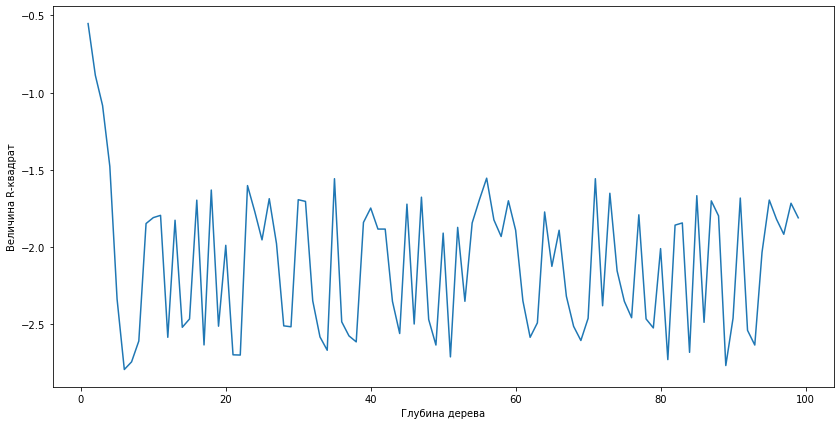

In [78]:
r_scores, depths = iterate_over_depths(X, y, train_and_test)

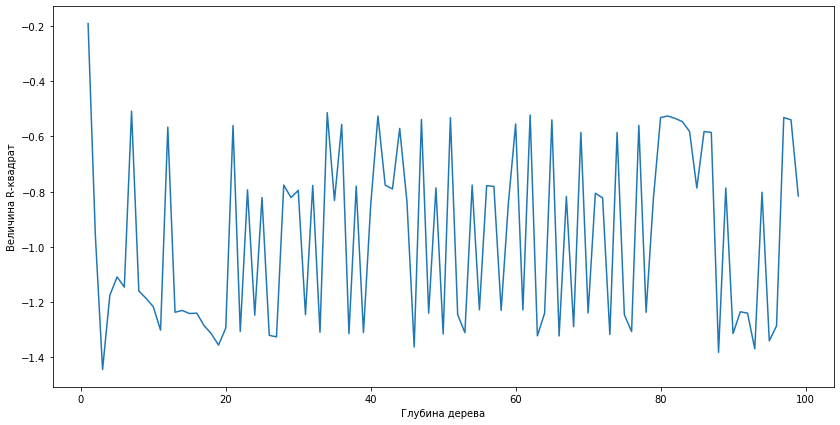

In [79]:
r_scores, depths = iterate_over_depths(X, y, train_and_test_shuffled)

In [108]:
y = spacemen["1st_Spaceman"][NEW_PHC_COLNAME]
X = spacemen["1st_Spaceman"].drop(columns=[NEW_PHC_COLNAME])
X.columns, y.name

(Index(['TRIMP1_mean_3_days', 'TRIMP2_mean_3_days', 'TRIMP3_mean_3_days',
        'TRIMP4_mean_3_days', 'PhC_mean_3_days'],
       dtype='object'), 'PhC_mean_target_3_days')

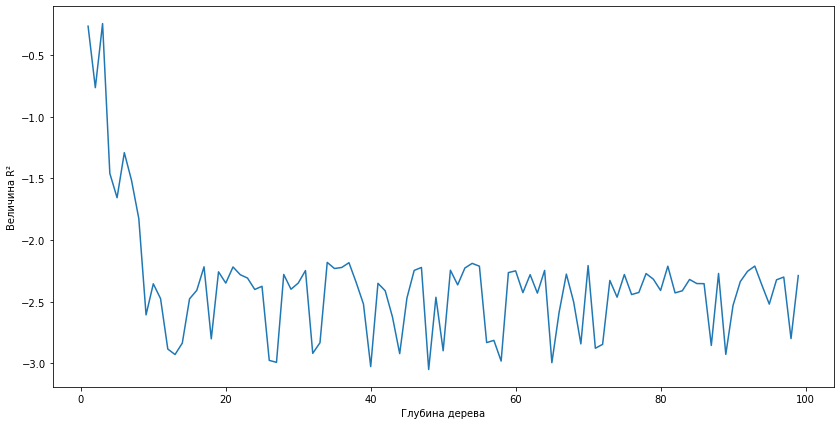

In [109]:
r_scores, depths = iterate_over_depths(X, y, train_and_test)

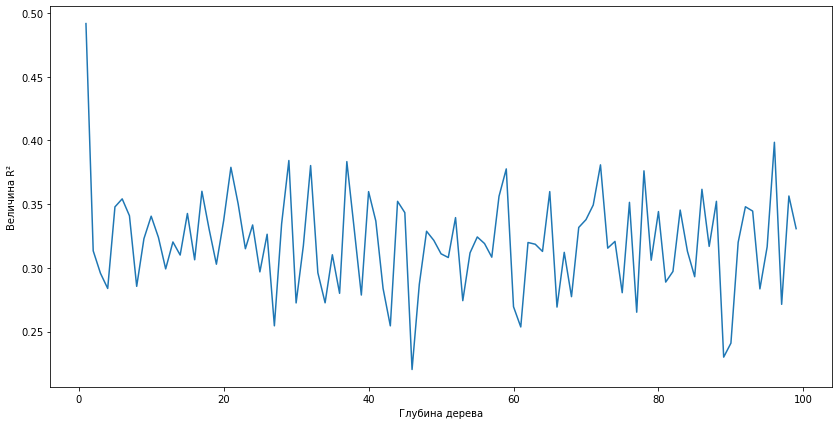

In [111]:
r_scores, depths = iterate_over_depths(X, y, train_and_test_shuffled)

In [112]:
y = spacemen["3rd_Spaceman"][NEW_PHC_COLNAME]
X = spacemen["3rd_Spaceman"].drop(columns=[NEW_PHC_COLNAME])
X.columns, y.name

(Index(['PhC_mean_3_days', 'TRIMP1_mean_3_days', 'TRIMP2_mean_3_days',
        'TRIMP3_mean_3_days', 'TRIMP4_mean_3_days'],
       dtype='object'), 'PhC_mean_target_3_days')

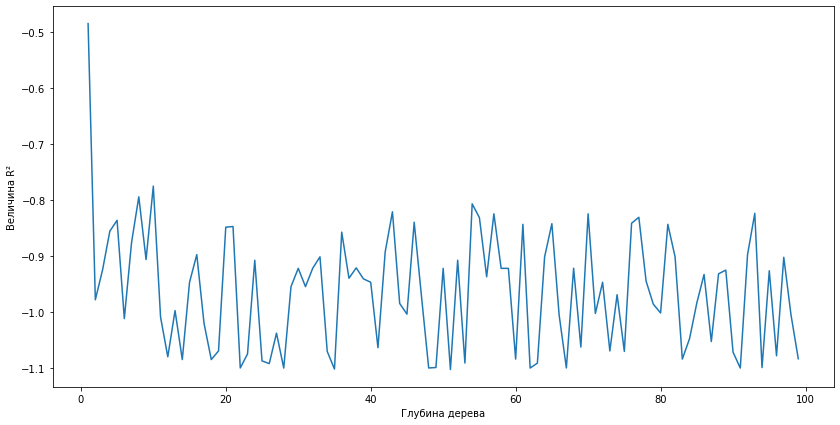

In [113]:
r_scores, depths = iterate_over_depths(X, y, train_and_test)

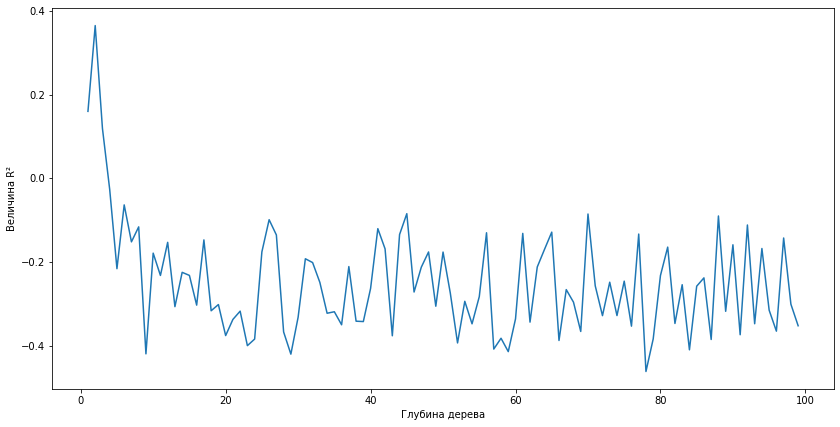

In [114]:
r_scores, depths = iterate_over_depths(X, y, train_and_test_shuffled)

In [104]:
y = spacemen["1st_Spaceman"][NEW_PHC_COLNAME]
X = spacemen["1st_Spaceman"].drop(columns=[NEW_PHC_COLNAME])
X.columns, y.name

(Index(['TRIMP1_mean_3_days', 'TRIMP2_mean_3_days', 'TRIMP3_mean_3_days',
        'TRIMP4_mean_3_days', 'PhC_mean_3_days'],
       dtype='object'), 'PhC_mean_target_3_days')

R^2 = 0.4917421118237927


Text(0, 0.5, 'Прогноз')

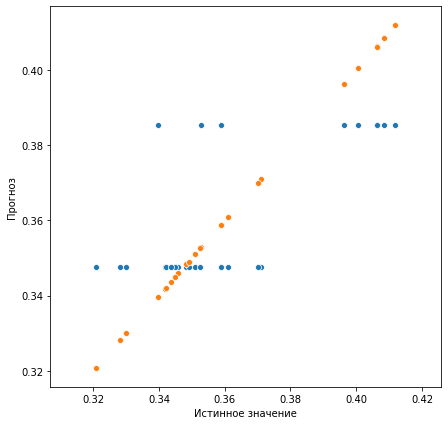

In [105]:
tree = DecisionTreeRegressor(criterion='mse', max_depth=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)
tree.fit(X_train, y_train)
y_pred = tree.predict(X_test)
r2 = r2_score(y_test, y_pred)
# mae = np.mean(np.abs(y_test - y_pred))

print(f'R^2 = {r2}')
plt.figure(figsize=(7,7))
sns.scatterplot(y_test, y_pred)
sns.scatterplot(y_test, y_test)
plt.xlabel('Истинное значение')
plt.ylabel('Прогноз')
# sns.scatterplot(y_train, y_train)
# sns.scatterplot(y_train, tree.predict(X_train))
# sns.scatterplot(y, tree.predict(X))
# sns.scatterplot(y, y)

R^2 = 0.30579473881217856


Text(0, 0.5, 'Прогноз')

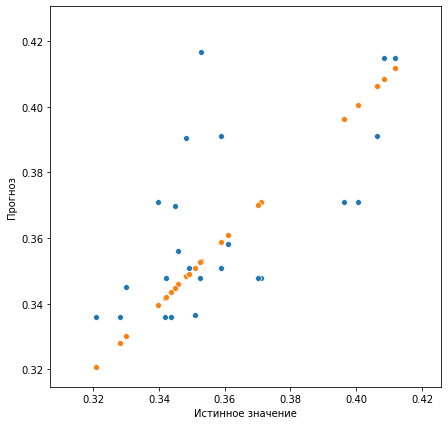

In [100]:
tree = DecisionTreeRegressor(criterion='mse', max_depth=5)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)
tree.fit(X_train, y_train)
y_pred = tree.predict(X_test)
r2 = r2_score(y_test, y_pred)
mae = np.mean(np.abs(y_test - y_pred))

print(f'R^2 = {r2}')
plt.figure(figsize=(7,7))
sns.scatterplot(y_test, y_pred)
sns.scatterplot(y_test, y_test)
plt.xlabel('Истинное значение')
plt.ylabel('Прогноз')

In [106]:
from sklearn.tree import export_graphviz
export_graphviz(tree, out_file='tree.dot', 
                feature_names = X.columns,
                class_names = y.name,
                rounded = True, proportion = False, 
                precision = 2, filled = True)

# Convert to png using system command (requires Graphviz)
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

0

R^2 = 0.43179788060209356


Text(0, 0.5, 'Прогноз')

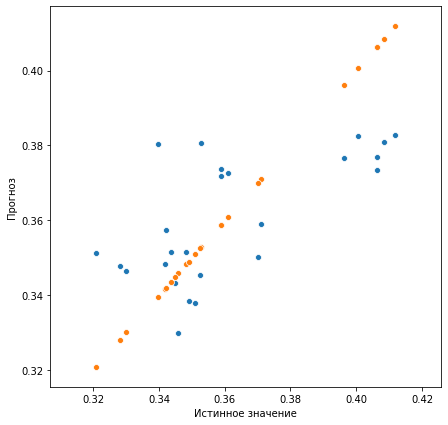

In [101]:
from sklearn.linear_model import LinearRegression
linear = LinearRegression(normalize=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)
linear.fit(X_train, y_train)
y_pred = linear.predict(X_test)
r2 = r2_score(y_test, y_pred)
mae = np.mean(np.abs(y_test - y_pred))

print(f'R^2 = {r2}')
plt.figure(figsize=(7,7))
sns.scatterplot(y_test, y_pred)
sns.scatterplot(y_test, y_test)
plt.xlabel('Истинное значение')
plt.ylabel('Прогноз')

R^2 = 0.4278699604084225


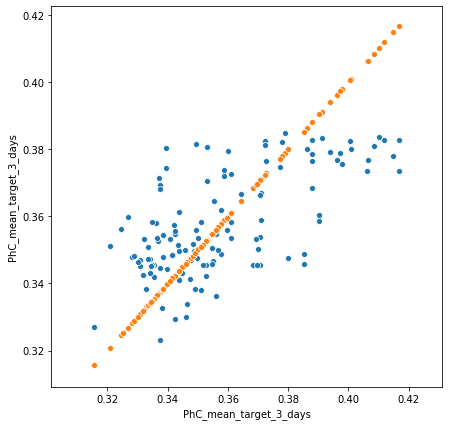

In [66]:
linear = LinearRegression(normalize=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)
linear.fit(X_train, y_train)
y_pred = linear.predict(X)
r2 = r2_score(y, y_pred)
# mae = np.mean(np.abs(y_test - y_pred))

print(f'R^2 = {r2}')
plt.figure(figsize=(7,7))
sns.scatterplot(y, y_pred)
sns.scatterplot(y, y)

In [67]:
y = spacemen["3rd_Spaceman"][NEW_PHC_COLNAME]
X = spacemen["3rd_Spaceman"].drop(columns=[NEW_PHC_COLNAME])
X.columns, y.name

(Index(['PhC_mean_3_days', 'TRIMP1_mean_3_days', 'TRIMP2_mean_3_days',
        'TRIMP3_mean_3_days', 'TRIMP4_mean_3_days'],
       dtype='object'), 'PhC_mean_target_3_days')

R^2 = -0.20943778761707188


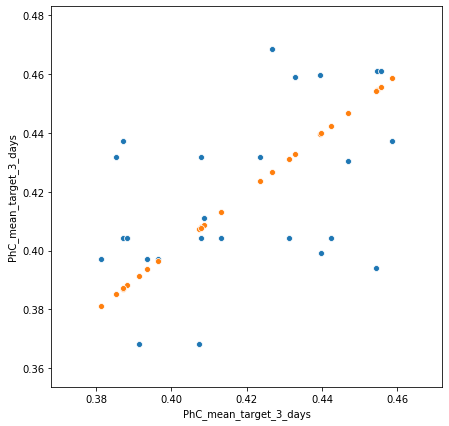

In [68]:
tree = DecisionTreeRegressor(criterion='mse', max_depth=5)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)
tree.fit(X_train, y_train)
y_pred = tree.predict(X_test)
r2 = r2_score(y_test, y_pred)
mae = np.mean(np.abs(y_test - y_pred))

print(f'R^2 = {r2}')
plt.figure(figsize=(7,7))
sns.scatterplot(y_test, y_pred)
sns.scatterplot(y_test, y_test)

R^2 = 0.20480779873336652


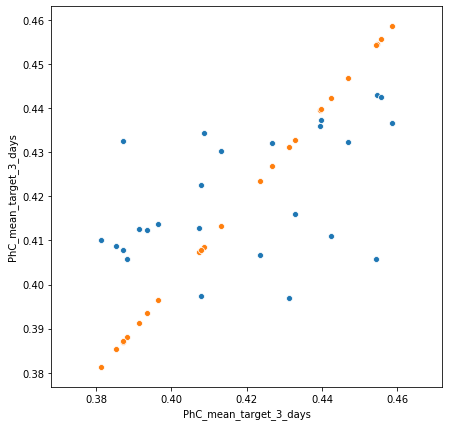

In [69]:
from sklearn.linear_model import LinearRegression
linear = LinearRegression(normalize=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)
linear.fit(X_train, y_train)
y_pred = linear.predict(X_test)
r2 = r2_score(y_test, y_pred)
mae = np.mean(np.abs(y_test - y_pred))

print(f'R^2 = {r2}')
plt.figure(figsize=(7,7))
sns.scatterplot(y_test, y_pred)
sns.scatterplot(y_test, y_test)

R^2 = 0.27108572437300127


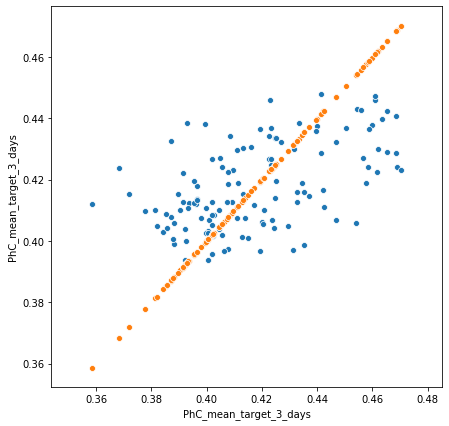

In [70]:
linear = LinearRegression(normalize=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)
linear.fit(X_train, y_train)
y_pred = linear.predict(X)
r2 = r2_score(y, y_pred)
# mae = np.mean(np.abs(y_test - y_pred))

print(f'R^2 = {r2}')
plt.figure(figsize=(7,7))
sns.scatterplot(y, y_pred)
sns.scatterplot(y, y)